In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from keras.utils import to_categorical 

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784')

In [5]:
nr_images = len(mnist.data.values)
all_images = mnist.data.values
all_labels = np.array(list(map(int, mnist.target.values)))

In [6]:
all_images = all_images / 255.0

# The Actual Active Learning Part

## Train the model - pick and label randomly

In [8]:
n = 2000;
result_random = {}
result_active_learn = {}

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.3, shuffle=True, random_state=1337
)

10


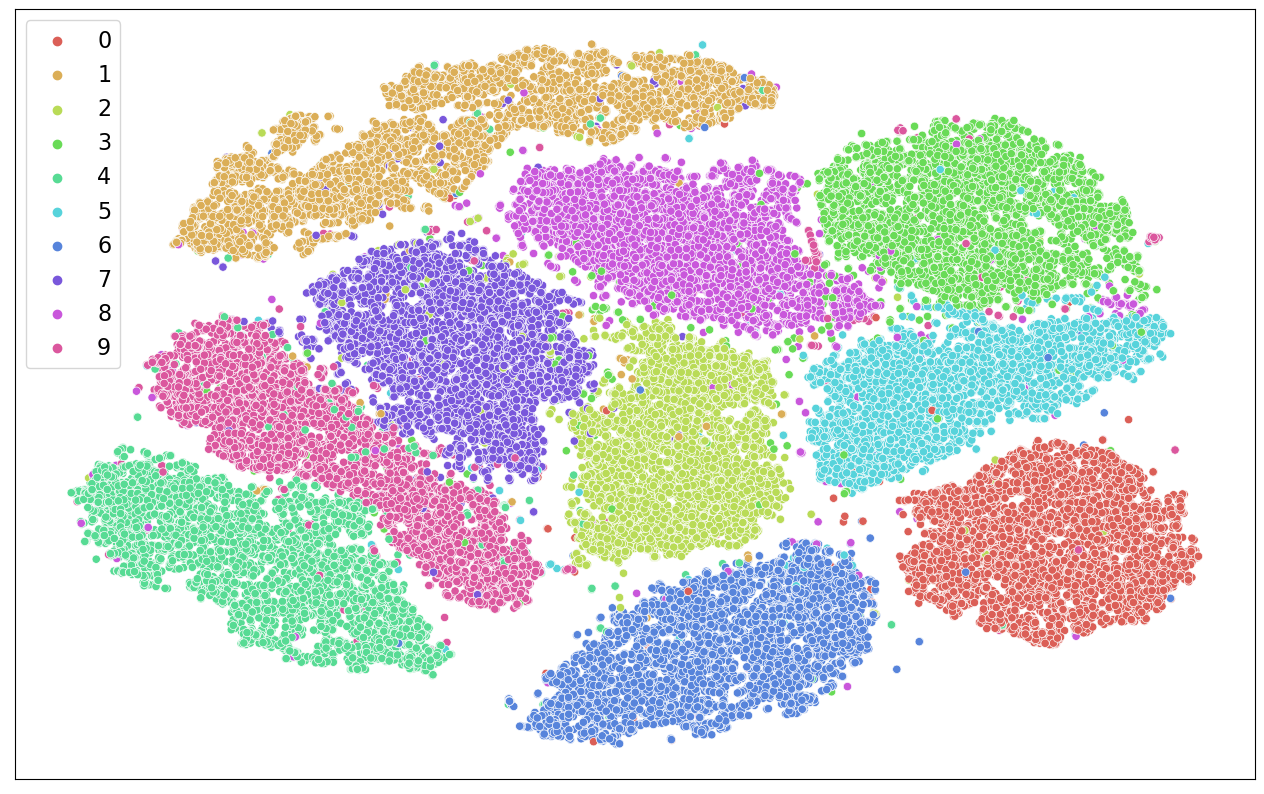

In [33]:
create_tSNE_plot(X_train, y_train, "full_mnist_tsne.png")

In [17]:
active_learning = False
y_values = pd.DataFrame()

X_pool = np.empty((0,784))
y_pool = np.empty((0,))

X_train, y_train, new_images, new_labels = pick_n_random_images(X_train, y_train, 1000)
X_pool, y_pool = add_samples_to_training_set(X_pool, y_pool, new_images, new_labels)

# Add data to the training pool until there is no more data in the training set
while len(X_train) > n: 
    
    # Train a new model on the training pool
    tf.keras.backend.clear_session()
    model = create_simple_model()
    fit_model_to_data(model, X_pool, y_pool)
    
    # Evaluate the model on testdata
    accuracy = evaluate_model(model, X_test, y_test)
    
    if active_learning:
        # Add the accuracy of the current model to dict
        result_active_learn[len(X_pool)] = accuracy
        
        # Pick new images for training using a dataselection algorithm
        X_train, y_train, new_images, new_labels = pick_n_least_confident_images(
            X_train, 
            y_train, 
            n, 
            model
        )
    else:
        # Add the accuracy of the current model to dict
        result_random[len(X_pool)] = accuracy
        
        # Pick new images for training at random
        X_train, y_train, new_images, new_labels = pick_n_random_images(
            X_train, 
            y_train, 
            n
        )
    
    # Add the new images to the training pool
    X_pool, y_pool = add_samples_to_training_set(X_pool, y_pool, new_images, new_labels)

657/657 [==============================] - 1s 2ms/step


# Visualization Part

[]

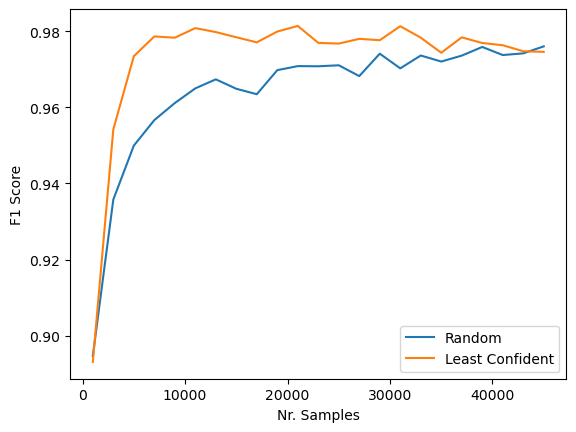

In [18]:
df = pd.DataFrame([result_random, result_active_learn]).T
df.columns = ['Random', 'Least Confident']

plot = df.plot()
plot.set_xlabel("Nr. Samples")
plot.set_ylabel("F1 Score")
plot.plot()

## Helper functions

In [11]:
def add_samples_to_training_set(X_train, y_train, new_samples, new_labels):
    return np.concatenate((X_train, new_samples)), np.concatenate((y_train, new_labels))

In [12]:
def create_simple_model():
    model = Sequential(name="MNIST_Classifier")
    model.add(Dense(784, input_shape = (784,), activation="relu"))
    model.add(Dense(392, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam'
    )
    return model

In [13]:
def fit_model_to_data(model, X_pool, y_pool):
    y_one_hot = to_categorical(y_pool)
    model.fit(
        X_pool, # Samples
        y_one_hot, # Labels
        batch_size=128,
        epochs=10,
        verbose=0
    )

def evaluate_model(model, X_test, y_test):
    one_hot_predictions = model.predict(X_test)
    label_predictions = np.argmax(one_hot_predictions, axis=1)
    return f1_score(y_test, label_predictions, average='weighted')

In [14]:
def pick_n_random_images(X_train, y_train, n):
    '''
        Returns 4 arrays,
        the first two are the remaining images and labels after we have picked new
        samples for training, the second two are the random images and labels we have picked
    '''
    # Pick random indices 
    random_indices = np.random.choice(list(range(0, len(X_train))), n, replace=False)
    
    #Use the indices to pick random images and their corresponding labels
    random_imgs = X_train[random_indices]
    random_labels = y_train[random_indices]
    
    # Remove the images and labels from the training set
    X_train = np.delete(X_train, random_indices, axis=0)
    y_train = np.delete(y_train, random_indices, axis=0)
    
    return X_train, y_train, random_imgs, random_labels

def pick_n_least_confident_images(X_train, y_train, n, model):
    '''
        Returns 4 arrays,
        the first two are the remaining images and labels after we have picked new
        samples for training, the second two are the random images and labels we have picked
    '''
    # Make prediction on the training set (the samples that are "not labeled")
    preds = model.predict(X_train)
    
    # Create a DataFrame with the predictions, where each column contains the prediction for a given class
    df = pd.DataFrame(preds, columns=[0,1,2,3,4,5,6,7,8,9])
    
    # Find the highest predicted value for any class in the dataframe, store it in a new column called max
    df['max'] = df.max(axis=1)
    
    # Pick the n predictions with the smallest prediction score, i.e, the samples the model was the least confident in
    least_confident_predictions = df.nsmallest(n, columns=['max'])
    
    # Get the index of these images
    index_of_least_confident = least_confident_predictions.index.values
    
    # Pick the images and labels with the least confidence (simulating a human labeling these samples)
    images = X_train[index_of_least_confident]
    labels = y_train[index_of_least_confident]
    
    # Remove the images and labels from the training set
    X_train = np.delete(X_train, index_of_least_confident, axis=0)
    y_train = np.delete(y_train, index_of_least_confident, axis=0)
    
    return X_train, y_train, images, labels

In [31]:
def visualize_digits(images, labels):  
    _, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(10, 3))
    for ax, image, label in zip(axes, images, labels):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray)
        ax.set_title("Lbl" + str(label))

def create_tSNE_plot(images, labels, png_name):
    
    nr_different_labels = len(pd.Series(labels).value_counts())
    print(nr_different_labels)
    if(nr_different_labels == 2): # Set colors to black and red
        colors = ["#808080","#ff0000"]
        custom_palette = sns.set_palette(sns.color_palette(colors))
    else: 
        custom_palette = sns.hls_palette(10)
    
    # First use PCA to reduce dimensionality of images down to 50
    pca = PCA(n_components=50)
    pca_res = pca.fit_transform(images)
    
    # Apply t-SNE
    tsne = TSNE(n_components = 2, random_state=0)
    tsne_res = tsne.fit_transform(pca_res)
    
    # Plot t-SNE
    plt.figure(figsize=(16,10))
    #plt.rc('xtick', labelsize=18) 
    #plt.rc('ytick', labelsize=18)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.rc('legend', fontsize=16)
    sns.scatterplot(
        x = tsne_res[:,0], 
        y = tsne_res[:,1], 
        hue = labels, 
        palette = custom_palette, 
        legend = 'full'
    );

    # Save plot
    plt.savefig(png_name, bbox_inches='tight')
    